In [177]:
from __future__ import print_function
import numpy as np
np.random.seed(42)

In [178]:
class Layer:
    def __init__(self):
        self.weights = np.zeros(shape=(input.shape[1], 10))
        bias = np.zeros(shape=(10,))
        pass
    
    def forward(self, input):
        output = np.matmul(input, self.weights) + bias
        return output

In [181]:
class Dense(Layer):
    def __init__(self, input_units, output_units, learning_rate=0.1):
        self.learning_rate = learning_rate
        
        # initialize weights with small random numbers. We use normal initialization
        self.weights = np.random.randn(input_units, output_units)*0.01
        self.biases = np.zeros(output_units)
    def forward(self,input):
        return np.matmul(input, self.weights) + self.biases
    def backward(self,input,grad_output):
        # compute d f / d x = d f / d dense * d dense / d x
        # where d dense/ d x = weights transposed
        grad_input = np.dot(grad_output,np.transpose(self.weights))

        # compute gradient w.r.t. weights and biases
        grad_weights = np.transpose(np.dot(np.transpose(grad_output),input))
        grad_biases = np.sum(grad_output, axis = 0)
        
        # Here we perform a stochastic gradient descent step. 
        # Later on, you can try replacing that with something better.
        self.weights = self.weights - self.learning_rate * grad_weights
        self.biases = self.biases - self.learning_rate * grad_biases
        return grad_input

In [182]:
class ReLU(Layer):
    def __init__(self):
        """ReLU layer simply applies elementwise rectified linear unit to all inputs"""
        pass
    
    def forward(self, input):
        """Apply elementwise ReLU to [batch, input_units] matrix"""
        return np.maximum(0,input)

    def backward(self, input, grad_output):
        """Compute gradient of loss w.r.t. ReLU input"""
        relu_grad = input > 0
        return grad_output*relu_grad

In [183]:
def softmax_crossentropy_with_logits(logits,reference_answers):
    """Compute crossentropy from logits[batch,n_classes] and ids of correct answers"""
    logits_for_answers = logits[np.arange(len(logits)),reference_answers]
    
    xentropy = - logits_for_answers + np.log(np.sum(np.exp(logits),axis=-1))
    
    return xentropy

In [184]:
def grad_softmax_crossentropy_with_logits(logits,reference_answers):
    """Compute crossentropy gradient from logits[batch,n_classes] and ids of correct answers"""
    ones_for_answers = np.zeros_like(logits)
    ones_for_answers[np.arange(len(logits)),reference_answers] = 1
    
    softmax = np.exp(logits) / np.exp(logits).sum(axis=-1,keepdims=True)
    
    return (- ones_for_answers + softmax) / logits.shape[0]

In [185]:
import keras

In [186]:
import keras
def load_dataset(flatten=False):
    (X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()

    # normalize x
    X_train = X_train.astype(float) / 255.
    X_test = X_test.astype(float) / 255.

    # we reserve the last 10000 training examples for validation
    X_train, X_val = X_train[:-10000], X_train[-10000:]
    y_train, y_val = y_train[:-10000], y_train[-10000:]

    if flatten:
        X_train = X_train.reshape([X_train.shape[0], -1])
        X_val = X_val.reshape([X_val.shape[0], -1])
        X_test = X_test.reshape([X_test.shape[0], -1])

    return X_train, y_train, X_val, y_val, X_test, y_test

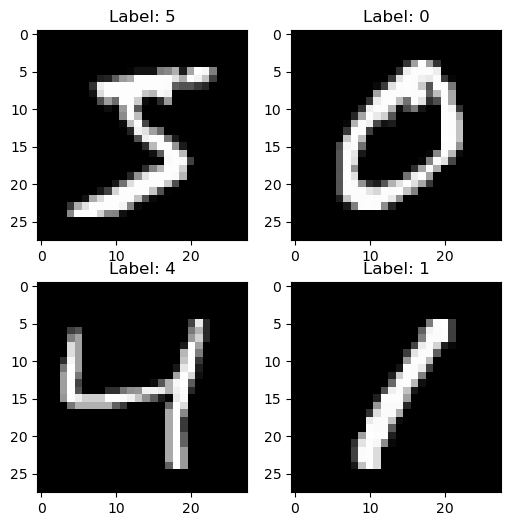

In [187]:
import matplotlib.pyplot as plt
X_train, y_train, X_val, y_val, X_test, y_test = load_dataset(flatten=True)

plt.figure(figsize=[6,6])
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.title("Label: %i"%y_train[i])
    plt.imshow(X_train[i].reshape([28,28]),cmap='gray');

In [197]:
network = []
network.append(Dense(X_train.shape[1],100))
network.append(ReLU())
network.append(Dense(100,200))
network.append(ReLU())
network.append(Dense(200,10))

In [198]:
def forward(network, X):
    """
    Compute activations of all network layers by applying them sequentially.
    Return a list of activations for each layer. 
    Make sure last activation corresponds to network logits.
    """
    activations = []
    input = X
    for i in range(len(network)):
        activations.append(network[i].forward(X))
        X = network[i].forward(X)
        
    assert len(activations) == len(network)
    return activations

In [199]:
def predict(network,X):
    """
    Compute network predictions.
    """
    logits = forward(network,X)[-1]
    return logits.argmax(axis=-1)

In [200]:
def train(network,X,y):
    """
    Train your network on a given batch of X and y.
    You first need to run forward to get all layer activations.
    Then you can run layer.backward going from last to first layer.
    After you called backward for all layers, all Dense layers have already made one gradient step.
    """
    
    # Get the layer activations
    layer_activations = forward(network,X)
    logits = layer_activations[-1]
    
    # Compute the loss and the initial gradient
    loss = softmax_crossentropy_with_logits(logits,y)
    loss_grad = grad_softmax_crossentropy_with_logits(logits,y)
    
    for i in range(1, len(network)):
        loss_grad = network[len(network) - i].backward(layer_activations[len(network) - i - 1], loss_grad)
    
    return np.mean(loss)

In [201]:
from tqdm import trange

In [202]:
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.random.permutation(len(inputs))
    for start_idx in trange(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

100%|████████████████████████████████████████████████████████████████████████████| 1562/1562 [00:00<00:00, 1853.34it/s]


Epoch 0
Train accuracy: 0.45248
Val accuracy: 0.4588


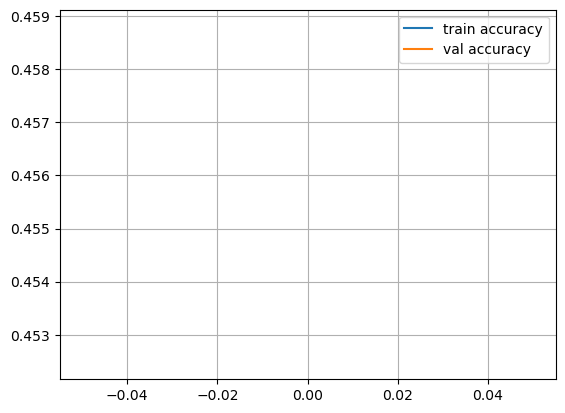

100%|████████████████████████████████████████████████████████████████████████████| 1562/1562 [00:00<00:00, 1812.79it/s]


Epoch 1
Train accuracy: 0.72342
Val accuracy: 0.7437


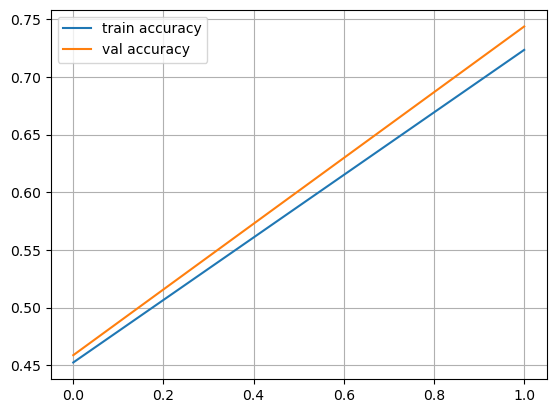

100%|████████████████████████████████████████████████████████████████████████████| 1562/1562 [00:00<00:00, 1869.23it/s]


Epoch 2
Train accuracy: 0.77398
Val accuracy: 0.7923


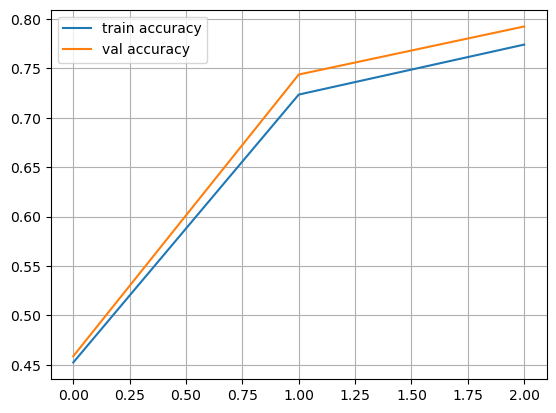

100%|████████████████████████████████████████████████████████████████████████████| 1562/1562 [00:00<00:00, 1763.92it/s]


Epoch 3
Train accuracy: 0.79862
Val accuracy: 0.8156


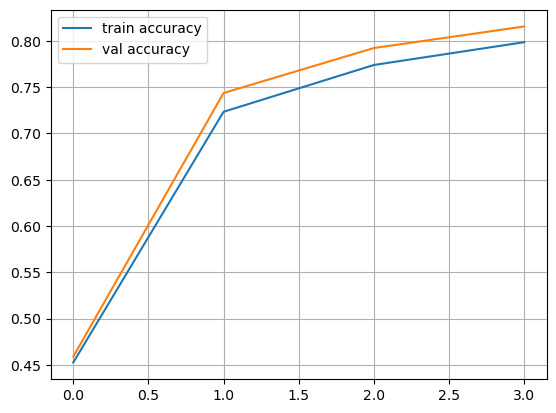

100%|████████████████████████████████████████████████████████████████████████████| 1562/1562 [00:00<00:00, 1749.99it/s]


Epoch 4
Train accuracy: 0.82014
Val accuracy: 0.8357


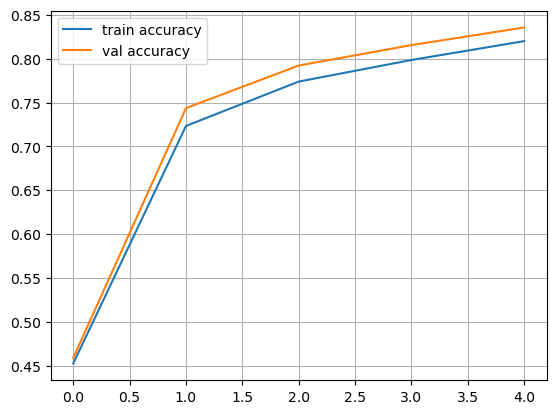

100%|████████████████████████████████████████████████████████████████████████████| 1562/1562 [00:00<00:00, 1816.70it/s]


Epoch 5
Train accuracy: 0.82902
Val accuracy: 0.8469


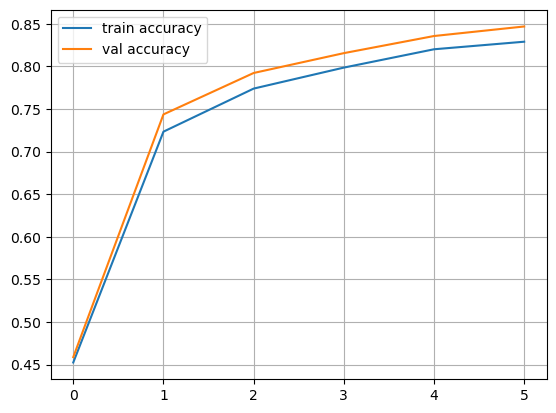

100%|████████████████████████████████████████████████████████████████████████████| 1562/1562 [00:00<00:00, 1733.46it/s]


Epoch 6
Train accuracy: 0.83736
Val accuracy: 0.8545


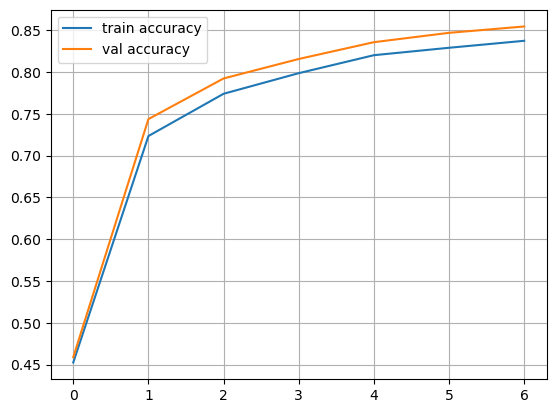

100%|████████████████████████████████████████████████████████████████████████████| 1562/1562 [00:00<00:00, 1842.44it/s]


Epoch 7
Train accuracy: 0.8442
Val accuracy: 0.8583


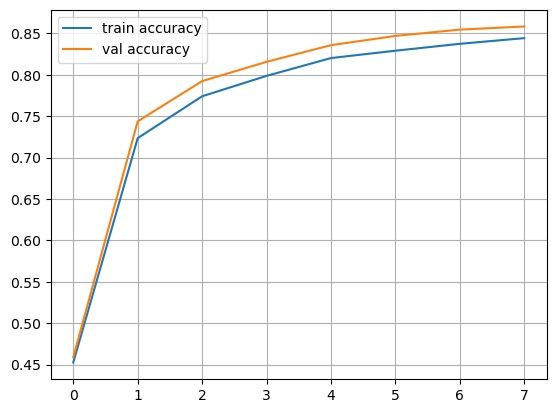

100%|████████████████████████████████████████████████████████████████████████████| 1562/1562 [00:00<00:00, 1785.88it/s]


Epoch 8
Train accuracy: 0.85112
Val accuracy: 0.8628


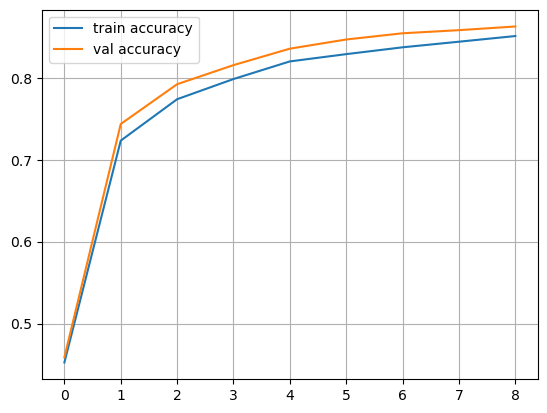

100%|████████████████████████████████████████████████████████████████████████████| 1562/1562 [00:00<00:00, 1748.91it/s]


Epoch 9
Train accuracy: 0.84582
Val accuracy: 0.8586


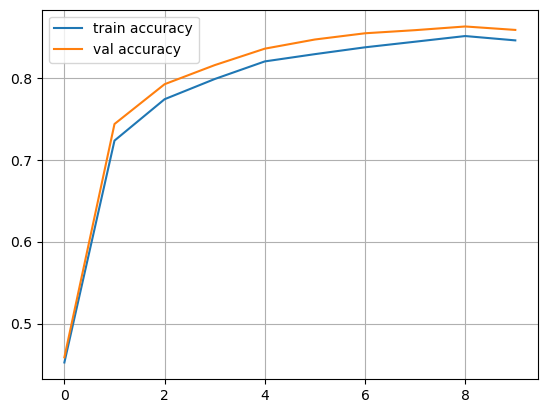

100%|████████████████████████████████████████████████████████████████████████████| 1562/1562 [00:00<00:00, 1824.79it/s]


Epoch 10
Train accuracy: 0.8586
Val accuracy: 0.8698


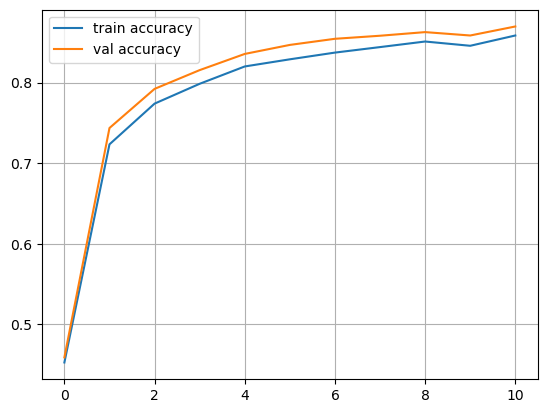

100%|████████████████████████████████████████████████████████████████████████████| 1562/1562 [00:00<00:00, 1753.68it/s]


Epoch 11
Train accuracy: 0.86136
Val accuracy: 0.8737


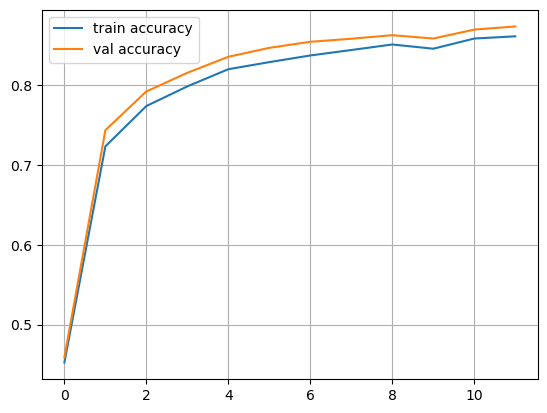

100%|████████████████████████████████████████████████████████████████████████████| 1562/1562 [00:00<00:00, 1748.97it/s]


Epoch 12
Train accuracy: 0.86764
Val accuracy: 0.8776


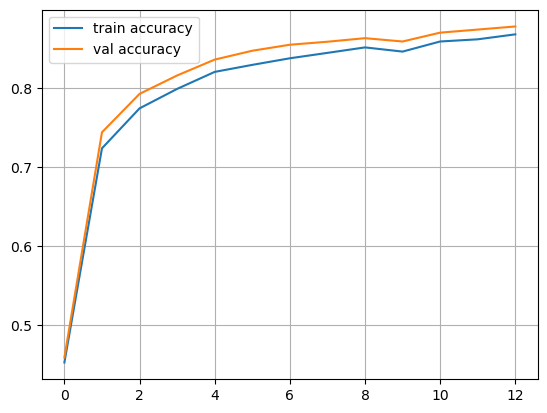

100%|████████████████████████████████████████████████████████████████████████████| 1562/1562 [00:00<00:00, 1803.68it/s]


Epoch 13
Train accuracy: 0.8681
Val accuracy: 0.8775


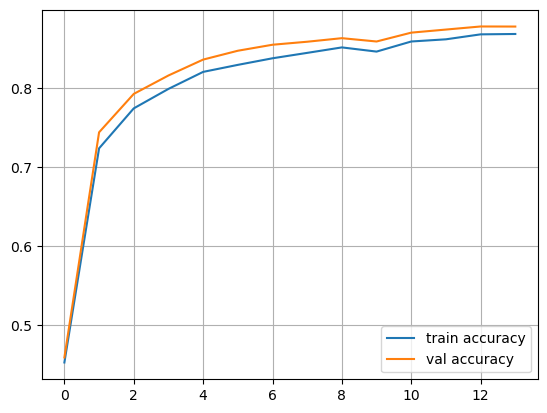

100%|████████████████████████████████████████████████████████████████████████████| 1562/1562 [00:00<00:00, 1802.39it/s]


Epoch 14
Train accuracy: 0.8722
Val accuracy: 0.8802


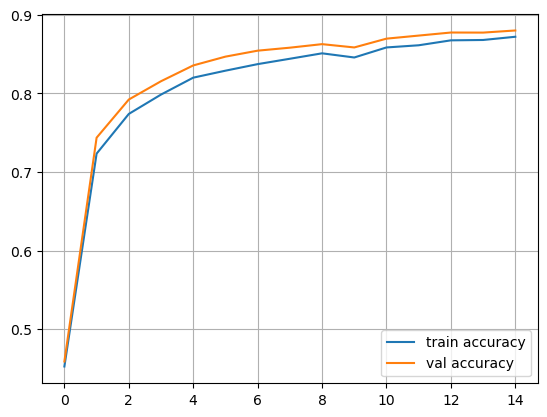

100%|████████████████████████████████████████████████████████████████████████████| 1562/1562 [00:00<00:00, 1823.43it/s]


Epoch 15
Train accuracy: 0.8773
Val accuracy: 0.8864


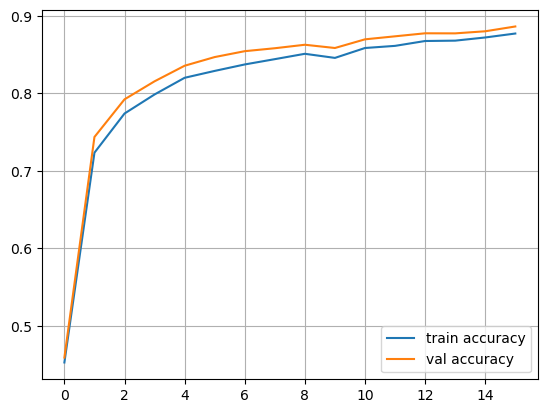

100%|████████████████████████████████████████████████████████████████████████████| 1562/1562 [00:00<00:00, 1729.26it/s]


Epoch 16
Train accuracy: 0.88024
Val accuracy: 0.8873


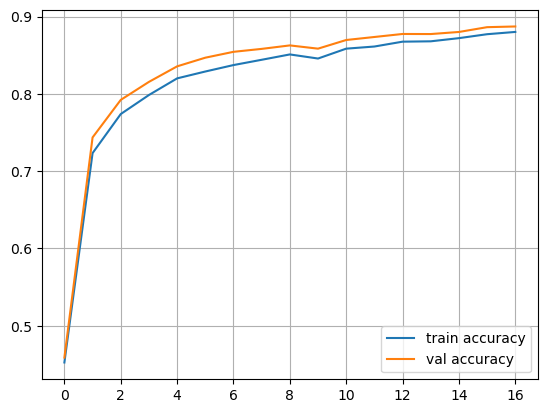

100%|████████████████████████████████████████████████████████████████████████████| 1562/1562 [00:00<00:00, 1779.43it/s]


Epoch 17
Train accuracy: 0.88362
Val accuracy: 0.8912


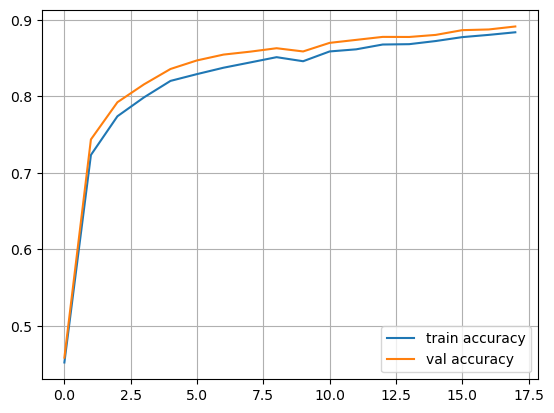

100%|████████████████████████████████████████████████████████████████████████████| 1562/1562 [00:00<00:00, 1764.03it/s]


Epoch 18
Train accuracy: 0.88666
Val accuracy: 0.8937


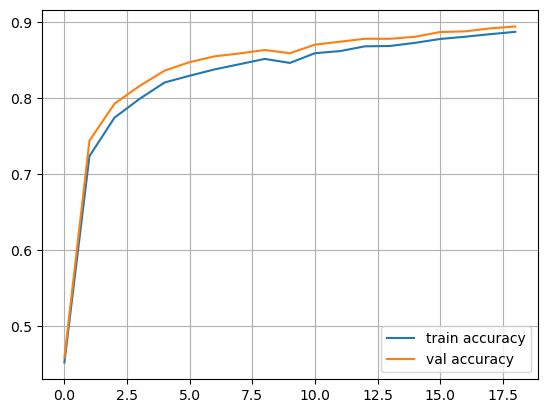

100%|████████████████████████████████████████████████████████████████████████████| 1562/1562 [00:00<00:00, 1764.17it/s]


Epoch 19
Train accuracy: 0.89028
Val accuracy: 0.8985


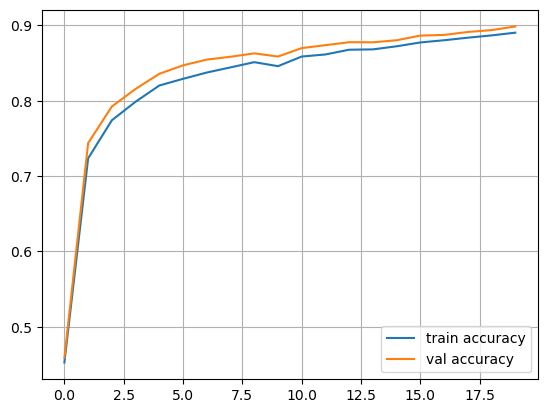

100%|████████████████████████████████████████████████████████████████████████████| 1562/1562 [00:00<00:00, 1741.89it/s]


Epoch 20
Train accuracy: 0.89328
Val accuracy: 0.9004


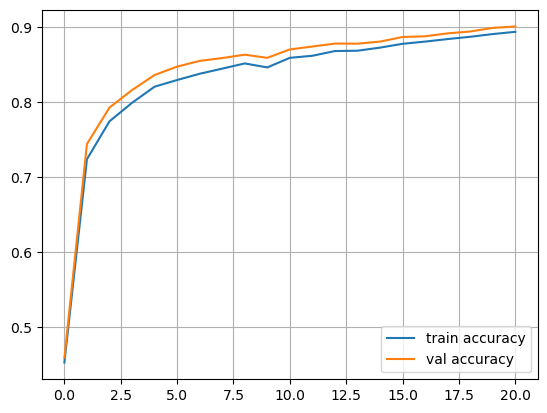

100%|████████████████████████████████████████████████████████████████████████████| 1562/1562 [00:00<00:00, 1755.28it/s]


Epoch 21
Train accuracy: 0.89488
Val accuracy: 0.9009


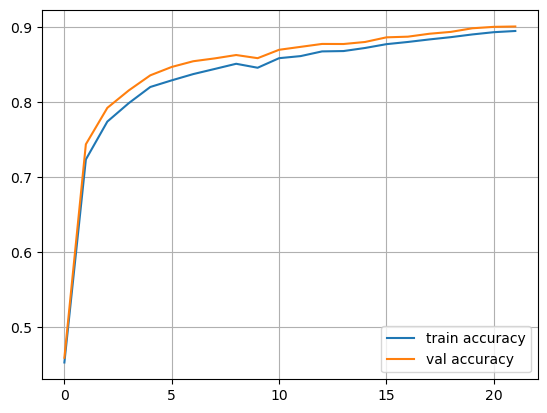

100%|████████████████████████████████████████████████████████████████████████████| 1562/1562 [00:00<00:00, 1699.05it/s]


Epoch 22
Train accuracy: 0.89854
Val accuracy: 0.9054


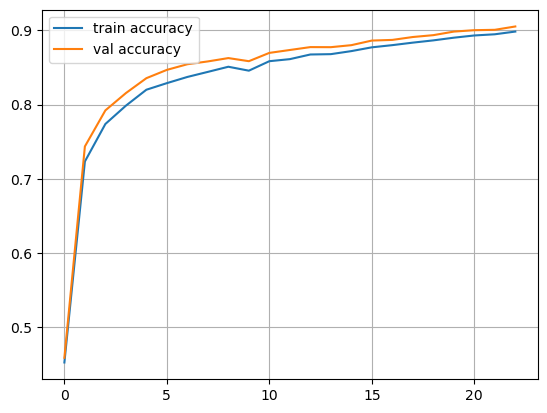

100%|████████████████████████████████████████████████████████████████████████████| 1562/1562 [00:00<00:00, 1753.94it/s]


Epoch 23
Train accuracy: 0.89918
Val accuracy: 0.9052


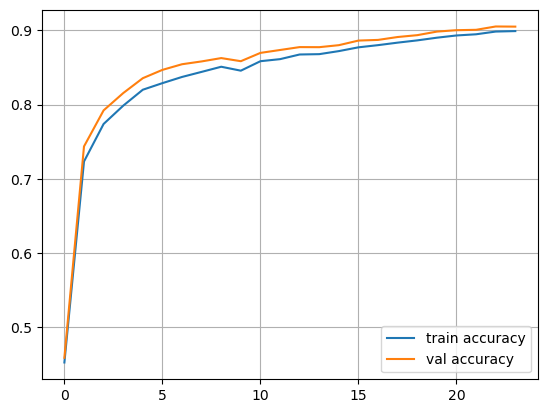

100%|████████████████████████████████████████████████████████████████████████████| 1562/1562 [00:00<00:00, 1764.33it/s]


Epoch 24
Train accuracy: 0.90426
Val accuracy: 0.9099


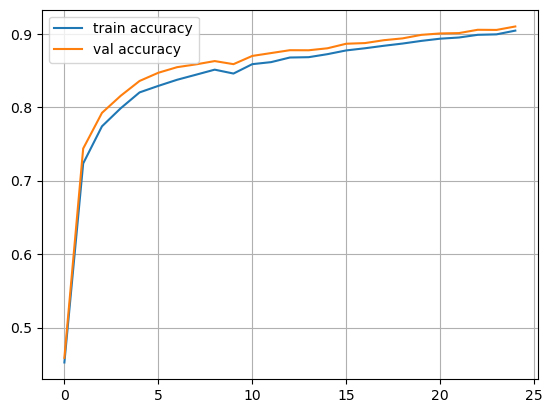

100%|████████████████████████████████████████████████████████████████████████████| 1562/1562 [00:00<00:00, 1786.41it/s]


Epoch 25
Train accuracy: 0.90044
Val accuracy: 0.9055


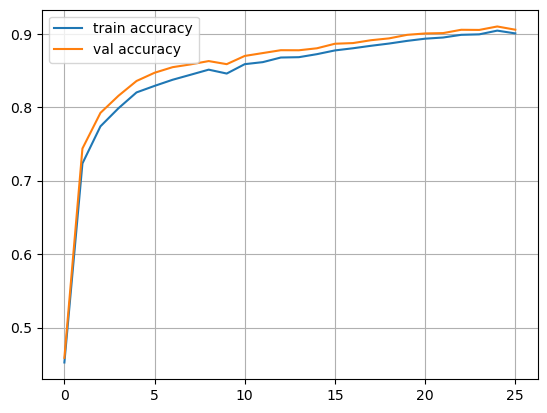

100%|████████████████████████████████████████████████████████████████████████████| 1562/1562 [00:00<00:00, 1784.30it/s]


Epoch 26
Train accuracy: 0.90678
Val accuracy: 0.9119


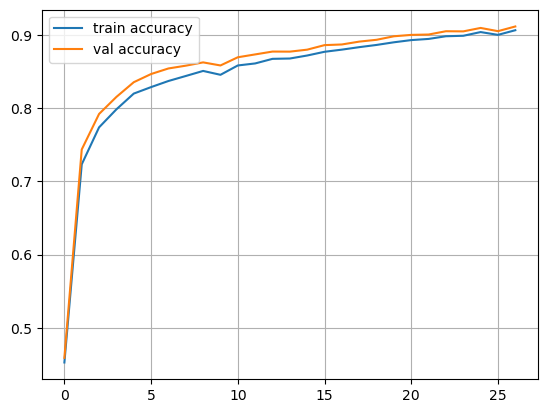

100%|████████████████████████████████████████████████████████████████████████████| 1562/1562 [00:00<00:00, 1765.70it/s]


Epoch 27
Train accuracy: 0.9043
Val accuracy: 0.9062


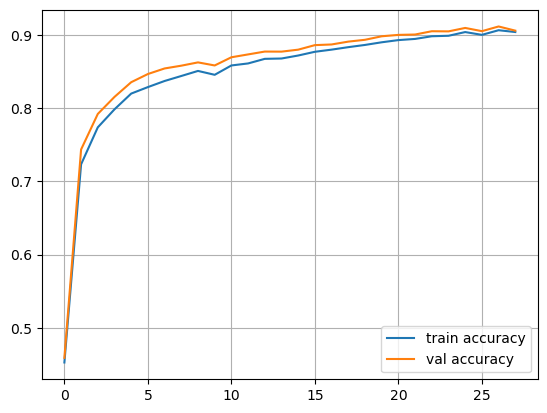

100%|████████████████████████████████████████████████████████████████████████████| 1562/1562 [00:00<00:00, 1663.69it/s]


Epoch 28
Train accuracy: 0.91126
Val accuracy: 0.9167


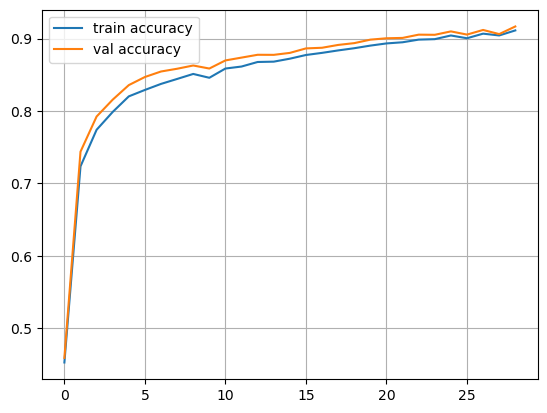

100%|████████████████████████████████████████████████████████████████████████████| 1562/1562 [00:00<00:00, 1640.41it/s]


Epoch 29
Train accuracy: 0.90808
Val accuracy: 0.91


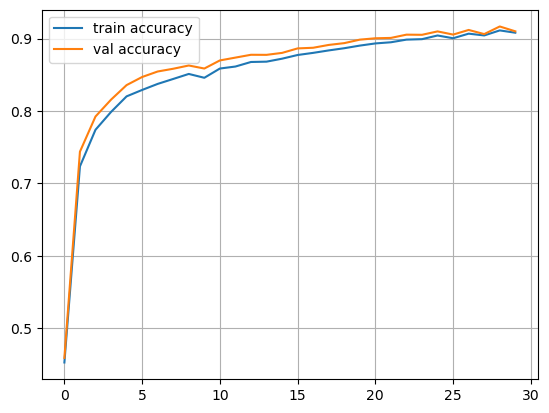

100%|████████████████████████████████████████████████████████████████████████████| 1562/1562 [00:00<00:00, 1831.42it/s]


Epoch 30
Train accuracy: 0.91502
Val accuracy: 0.9173


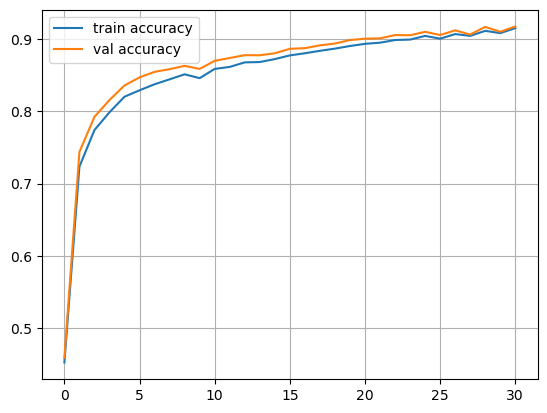

100%|████████████████████████████████████████████████████████████████████████████| 1562/1562 [00:00<00:00, 1798.66it/s]


Epoch 31
Train accuracy: 0.91438
Val accuracy: 0.9167


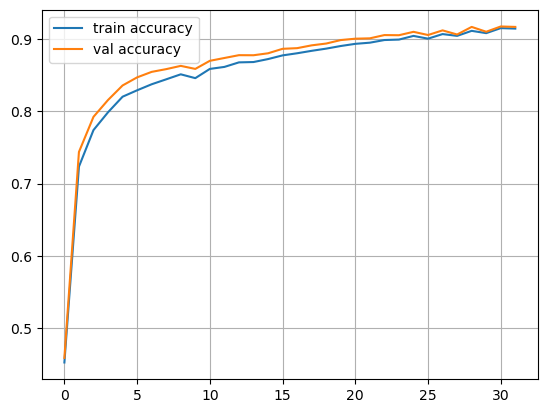

100%|████████████████████████████████████████████████████████████████████████████| 1562/1562 [00:00<00:00, 1743.46it/s]


Epoch 32
Train accuracy: 0.9196
Val accuracy: 0.919


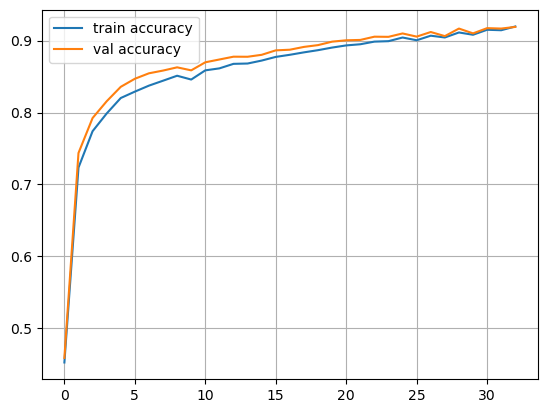

100%|████████████████████████████████████████████████████████████████████████████| 1562/1562 [00:00<00:00, 1784.90it/s]


Epoch 33
Train accuracy: 0.91862
Val accuracy: 0.9195


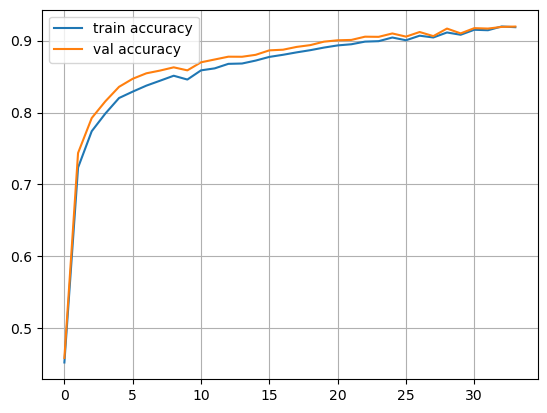

100%|████████████████████████████████████████████████████████████████████████████| 1562/1562 [00:00<00:00, 1653.33it/s]


Epoch 34
Train accuracy: 0.92078
Val accuracy: 0.9226


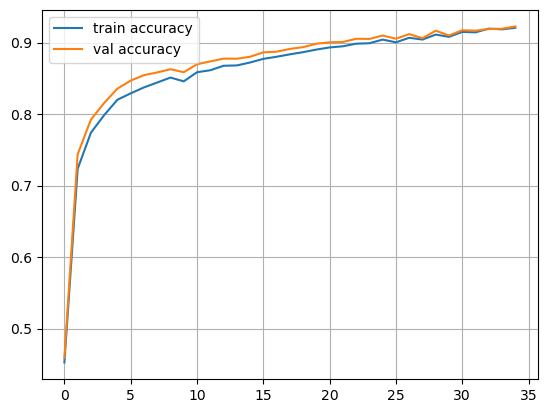

100%|████████████████████████████████████████████████████████████████████████████| 1562/1562 [00:00<00:00, 1870.76it/s]


Epoch 35
Train accuracy: 0.9221
Val accuracy: 0.9231


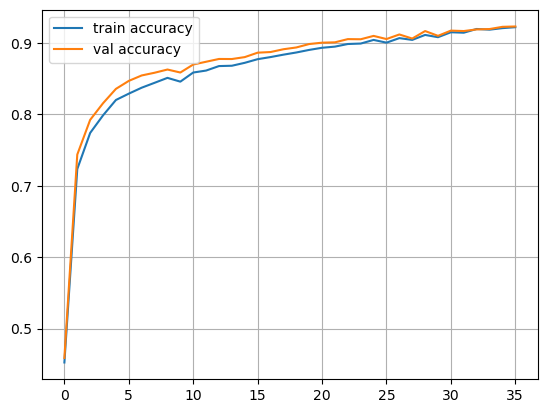

100%|████████████████████████████████████████████████████████████████████████████| 1562/1562 [00:00<00:00, 1798.21it/s]


Epoch 36
Train accuracy: 0.9234
Val accuracy: 0.9239


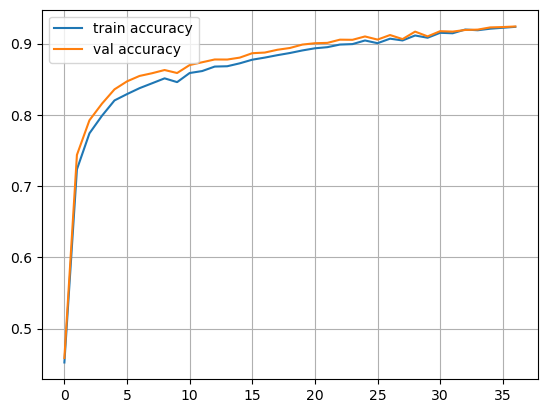

100%|████████████████████████████████████████████████████████████████████████████| 1562/1562 [00:00<00:00, 1726.71it/s]


Epoch 37
Train accuracy: 0.9269
Val accuracy: 0.9228


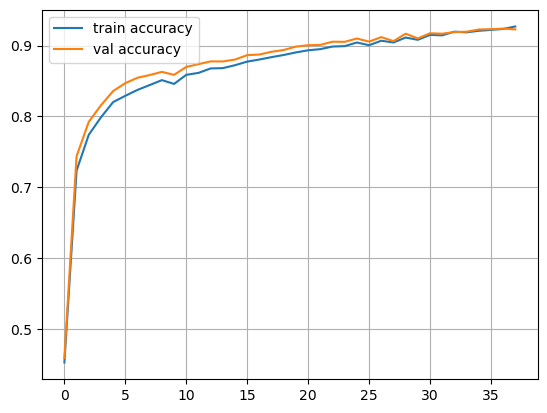

100%|████████████████████████████████████████████████████████████████████████████| 1562/1562 [00:00<00:00, 1738.31it/s]


Epoch 38
Train accuracy: 0.9255
Val accuracy: 0.9258


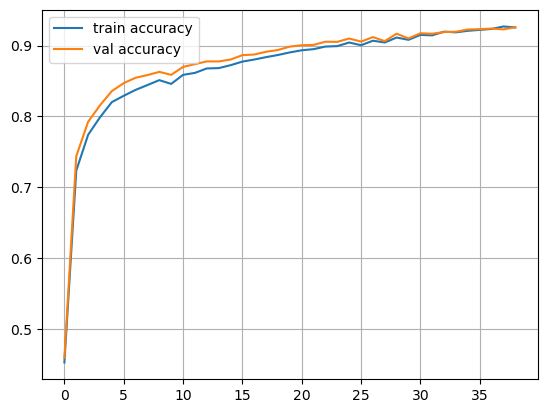

100%|████████████████████████████████████████████████████████████████████████████| 1562/1562 [00:00<00:00, 1739.56it/s]


Epoch 39
Train accuracy: 0.92652
Val accuracy: 0.9256


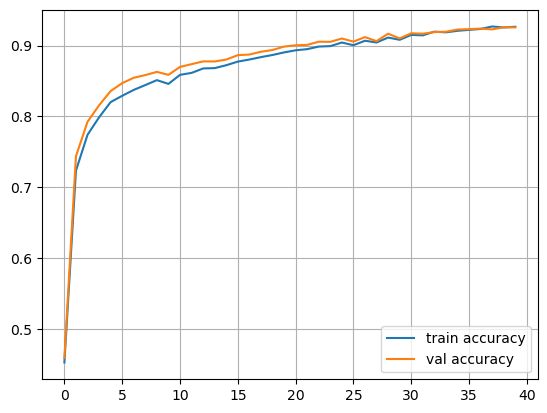

100%|████████████████████████████████████████████████████████████████████████████| 1562/1562 [00:00<00:00, 1685.84it/s]


Epoch 40
Train accuracy: 0.92904
Val accuracy: 0.9285


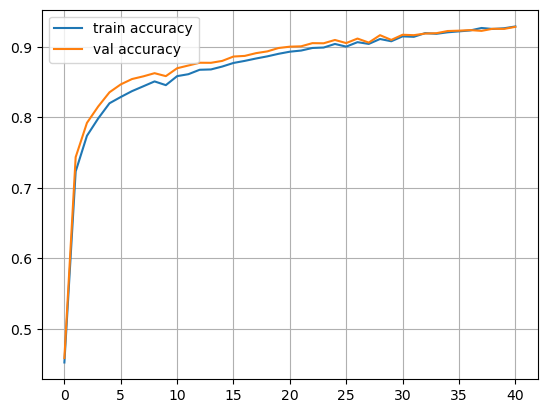

100%|████████████████████████████████████████████████████████████████████████████| 1562/1562 [00:00<00:00, 1734.05it/s]


Epoch 41
Train accuracy: 0.92902
Val accuracy: 0.9284


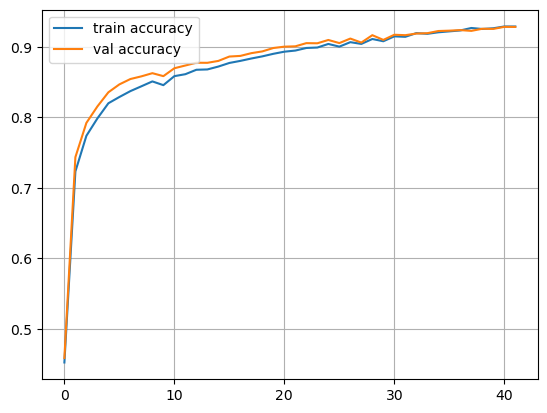

100%|████████████████████████████████████████████████████████████████████████████| 1562/1562 [00:00<00:00, 1769.83it/s]


Epoch 42
Train accuracy: 0.93066
Val accuracy: 0.929


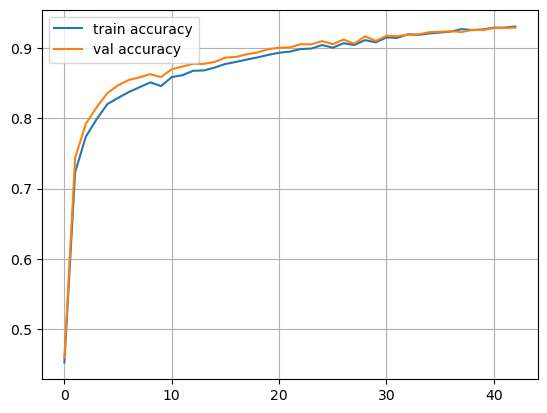

100%|████████████████████████████████████████████████████████████████████████████| 1562/1562 [00:00<00:00, 1764.52it/s]


Epoch 43
Train accuracy: 0.93138
Val accuracy: 0.9314


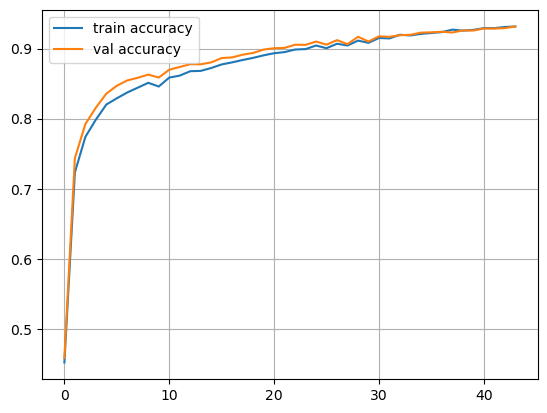

100%|████████████████████████████████████████████████████████████████████████████| 1562/1562 [00:00<00:00, 1707.74it/s]


Epoch 44
Train accuracy: 0.93402
Val accuracy: 0.9307


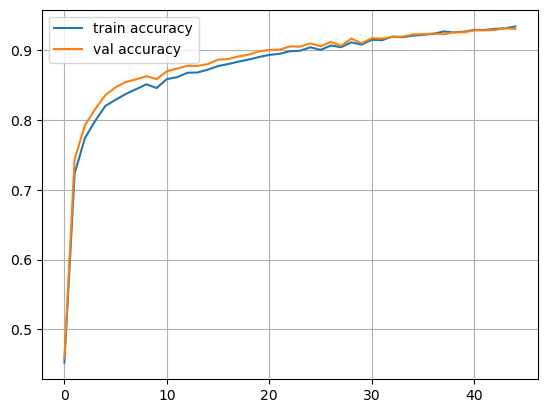

100%|████████████████████████████████████████████████████████████████████████████| 1562/1562 [00:00<00:00, 1768.58it/s]


Epoch 45
Train accuracy: 0.93362
Val accuracy: 0.9314


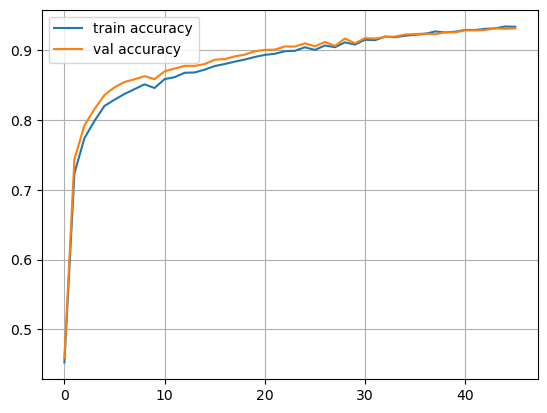

100%|████████████████████████████████████████████████████████████████████████████| 1562/1562 [00:00<00:00, 1667.27it/s]


Epoch 46
Train accuracy: 0.93402
Val accuracy: 0.9322


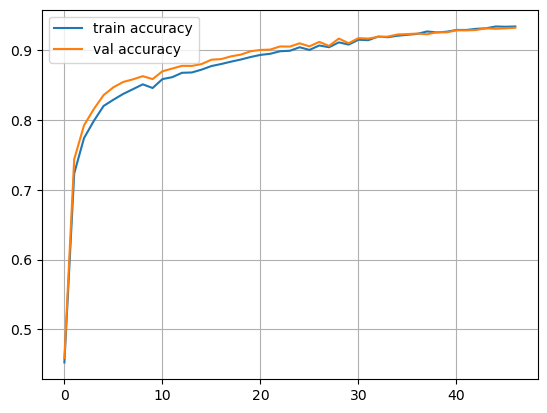

100%|████████████████████████████████████████████████████████████████████████████| 1562/1562 [00:00<00:00, 1660.57it/s]


Epoch 47
Train accuracy: 0.93458
Val accuracy: 0.933


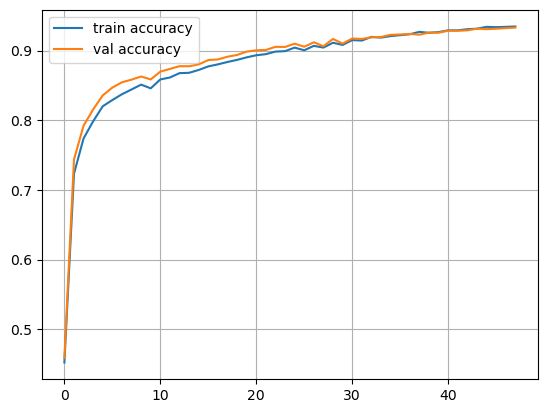

100%|████████████████████████████████████████████████████████████████████████████| 1562/1562 [00:00<00:00, 1783.76it/s]


Epoch 48
Train accuracy: 0.93528
Val accuracy: 0.9326


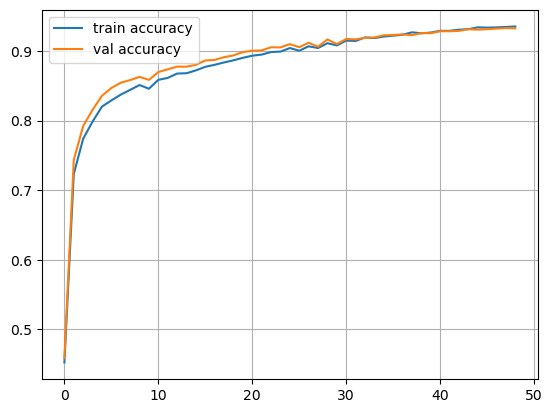

100%|████████████████████████████████████████████████████████████████████████████| 1562/1562 [00:00<00:00, 1761.48it/s]


Epoch 49
Train accuracy: 0.93706
Val accuracy: 0.9342


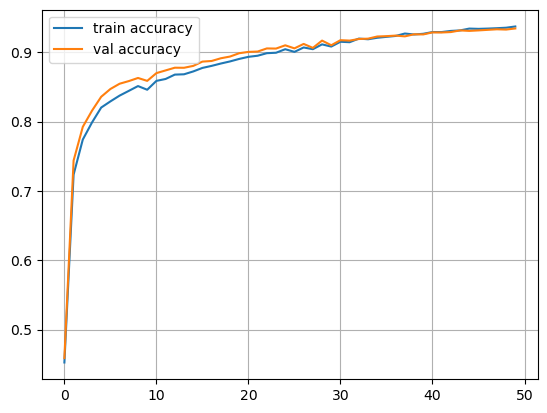

In [203]:
train_log = []
val_log = []
for epoch in range(50):

    for x_batch,y_batch in iterate_minibatches(X_train,y_train,batchsize=32,shuffle=True):
        train(network,x_batch,y_batch)
    
    train_log.append(np.mean(predict(network,X_train)==y_train))
    val_log.append(np.mean(predict(network,X_val)==y_val))
    
    print("Epoch",epoch)
    print("Train accuracy:",train_log[-1])
    print("Val accuracy:",val_log[-1])
    plt.plot(train_log,label='train accuracy')
    plt.plot(val_log,label='val accuracy')
    plt.legend(loc='best')
    plt.grid()
    plt.show()